In [204]:
import mlrose
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

import random
from timeit import default_timer as timer

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score

Credits:

This assignment uses [mlrose](https://github.com/gkhayes/mlrose) to implement randomised optimisation experiments. 

Hayes, G. (2019). mlrose: Machine Learning, Randomized Optimization and SEarch package for Python. https://github.com/gkhayes/mlrose.

And Prof. Charles Isbell's MIMIC tutorial.

Isbell, C.L. (2006). Randomized Local Search as Successive Estimation of Probability Densities.

# Weight Optimisation for Neural Network

The spotify song attributes dataset as Classification Problem 1 of my Assignment 1 is reused in this part, to find the optimised weight for a neural network model. The dataset specification is seen below:

Problem: Given list of attributes-carrying songs on spotify, labelled with sentiment ('like' or 'dislike') of a given person, predict the sentiment of that person towards a newly seen song.

Description of Dataset:

- Number of attributes: 13
- Number of instances: 2017
- Output: binary
- Source: [Kaggle](https://www.kaggle.com/geomack/spotifyclassification/version/1)

Hyperparameter optimisation from Assignment 1 chooses

- num_hidden_layers = 5
- batch_size = 112

with fixed model settings

- Size of each hidden layer: 100
- Solver: Adam
- Activation: ReLu

In Assignment 1, the best performing model for this spotify dataset was Decision Trees and Boosting, not Neural Networks. The final test-time accuracy was slightly above 50%. Therefore in this assignment, we investigate how  alternatives to the optimiser ma improve performance on the dataset. The problem is adjusted slightly as specified below.

The standard procedure to preprocess data is used, with a 80-20 train-test-set split, and one-hot encoding of the target train and test sets.

---

Adjustments made for Assignment 2:

Obviously since the solver (optimiser) is no longer a stochastic gradient variant, `batch_size` is no longer applicable here. In this Assignment, the following hypermeters would then be fixed

- num_hidden_layers = 5
- Size of each hidden layer: 10
- Activation: ReLu
- max_attempts = 100 : Maximum number of attempts in each iteration to find an improved neighbouring point
- clip_max : Clipped magnitude of weights

Note that to alleviate the issue of weight divergence (the magnitude of weights grows too large to give `NaN` values), the range of the weights are clipped by `[-1*clip_max, clip_max]` where:

- RHC: clip_max = 3
- SA, GA, MIMIC: clip_max = 1

---

And these three will be varied

- Solver: Randomised Hill Climbing (RHC), Simulated Annealing (SA) or Genetic Algorithm (GA)
- max_iter: Maximum number of iterations of the algorithm
- learning_rate: Learning rate

In order to see the performance of each randomised optimisation algorithm measured by test accuracy, and under which setting of `max_iter` and `learning_rate` would each of the algorithm gives the best result.

In [2]:
""" Loading dataset """
df = pd.read_csv('data/spotify_classification.csv')
y_key = 'target'
excluded_keys = [y_key, # y-targets
                 'Unnamed: 0', # id
                 'mode', # unknown
                 'song_title', 'artist' # text data not handled
                ]

X, y = df.drop(columns=excluded_keys), df[y_key]

#""" Ensure: (X, y) """

In [3]:
# Data preprocessing
X_train, X_test, y_train, y_test = train_test_split(np.asarray(X), np.asarray(y),
                                                   test_size=0.2, random_state=3)

## Normalise features to [0, 1]
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Data: one row per observation, numeric only
### categorical: one-hot encoded, continuous: as is
pass

## Targets: One-hot encoded
one_hot = OneHotEncoder()
y_train_hot = one_hot.fit_transform(y_train.reshape((-1, 1))).todense()
y_test_hot = one_hot.transform(y_test.reshape((-1, 1))).todense()

In [248]:
# Changed configurations
# batch_size non existent since not stochastic gradient descent

np.random.seed(3)

# class Optimiser:
#     name = ''
#     model = None
#     def run(self):
#         print(name)
        

# print(Optimiser().name)

# class RHC(Optimiser):
#     name = 'RHC'
# print(RHC().run())
    
def rhc(lr, max_iter, verbose=False, schedule=mlrose.ExpDecay(), pop_size=200, mutation_prob=0.1):
    if verbose:print('random_hill_climb', f'lr={lr}, max_iter={max_iter}')
    ##num_hidden_layers, hidden_layer_size = 5, 100
    ##hidden_nodes = np.full((num_hidden_layers, ), hidden_layer_size)
    nn_model = mlrose.NeuralNetwork(hidden_nodes=[10, 10, 10, 10, 10], activation='relu',
                                     algorithm='random_hill_climb', max_iters=max_iter,
                                     bias=True, is_classifier=True, learning_rate=lr,
                                     early_stopping=True,
                                     clip_max=3, # limit weights to magnitude of [-5, 5]
                                     max_attempts=100)

    # Fit model built-in optimised weights to produce a predictor
    nn_model.fit(X_train_scaled, y_train_hot)

    # Predict labels for train set and assess accuracy
    y_train_pred = nn_model.predict(X_train_scaled) # hypothesis
    y_train_accuracy = accuracy_score(y_train_hot, y_train_pred) # accuracy
    if verbose:print('Training accuracy: ', y_train_accuracy)

    # Predict labels for test set and assess accuracy
    y_test_pred = nn_model.predict(X_test_scaled)
    y_test_accuracy = accuracy_score(y_test_hot, y_test_pred)
    if verbose:print('Test accuracy: ', y_test_accuracy)
    return y_test_accuracy

def sa(lr, max_iter, verbose=False, schedule=mlrose.ExpDecay(), pop_size=200, mutation_prob=0.1):
    if verbose:print('simulated_annealing', f'lr={lr}, max_iter={max_iter}')
    nn_model = mlrose.NeuralNetwork(hidden_nodes=[10, 10, 10, 10, 10], activation='relu',
                                     algorithm='simulated_annealing', max_iters=max_iter,
                                     bias=True, is_classifier=True, learning_rate=lr,
                                     early_stopping=True,
                                     schedule=schedule,
                                     clip_max=1, # limit weights to magnitude of [-5, 5]
                                     max_attempts=100)

    # Fit model built-in optimised weights to produce a predictor
    nn_model.fit(X_train_scaled, y_train_hot)

    # Predict labels for train set and assess accuracy
    y_train_pred = nn_model.predict(X_train_scaled) # hypothesis
    y_train_accuracy = accuracy_score(y_train_hot, y_train_pred) # accuracy
    if verbose:print('Training accuracy: ', y_train_accuracy)

    # Predict labels for test set and assess accuracy
    y_test_pred = nn_model.predict(X_test_scaled)
    y_test_accuracy = accuracy_score(y_test_hot, y_test_pred)
    if verbose:print('Test accuracy: ', y_test_accuracy)
    return y_test_accuracy

def ga(lr, max_iter, verbose=False, schedule=mlrose.ExpDecay(), pop_size=200, mutation_prob=0.1):
    if verbose:print('genetic_algorithm', f'lr={lr}, max_iter={max_iter}')
    nn_model = mlrose.NeuralNetwork(hidden_nodes=[10, 10, 10, 10, 10], activation='relu',
                                     algorithm='genetic_alg', max_iters=max_iter,
                                     bias=True, is_classifier=True, learning_rate=lr,
                                     early_stopping=True, 
                                     pop_size=pop_size, mutation_prob=mutation_prob,
                                    # clip_max = 1 to avoid weight divergence to NaN
                                     clip_max=1, # limit weights to magnitude of [-5, 5]
                                     max_attempts=100)

    # Fit model built-in optimised weights to produce a predictor
    nn_model.fit(X_train_scaled, y_train_hot)

    # Predict labels for train set and assess accuracy
    y_train_pred = nn_model.predict(X_train_scaled) # hypothesis
    y_train_accuracy = accuracy_score(y_train_hot, y_train_pred) # accuracy
    if verbose:print('Training accuracy: ', y_train_accuracy)

    # Predict labels for test set and assess accuracy
    y_test_pred = nn_model.predict(X_test_scaled)
    y_test_accuracy = accuracy_score(y_test_hot, y_test_pred)
    if verbose:print('Test accuracy: ', y_test_accuracy)
    return y_test_accuracy

def gd(lr, max_iter, verbose=False, schedule=mlrose.ExpDecay(), pop_size=200, mutation_prob=0.1):
    if verbose:print('gradient_descent', f'lr={lr}, max_iter={max_iter}')
    nn_model = mlrose.NeuralNetwork(hidden_nodes=[10, 10, 10, 10, 10], activation='relu',
                                     algorithm='gradient_descent', max_iters=max_iter,
                                     bias=True, is_classifier=True, learning_rate=lr,
                                     early_stopping=True, 
                                    # clip_max = 1 to avoid weight divergence to NaN
                                     clip_max=1, # limit weights to magnitude of [-5, 5]
                                     max_attempts=100)

    # Fit model built-in optimised weights to produce a predictor
    nn_model.fit(X_train_scaled, y_train_hot)

    # Predict labels for train set and assess accuracy
    y_train_pred = nn_model.predict(X_train_scaled) # hypothesis
    y_train_accuracy = accuracy_score(y_train_hot, y_train_pred) # accuracy
    if verbose:print('Training accuracy: ', y_train_accuracy)

    # Predict labels for test set and assess accuracy
    y_test_pred = nn_model.predict(X_test_scaled)
    y_test_accuracy = accuracy_score(y_test_hot, y_test_pred)
    if verbose:print('Test accuracy: ', y_test_accuracy)
    return y_test_accuracy

In [263]:
# %%timeit -n1 -r1 -o
def nn_opt_heatmap(optimiser, algo_name, verbose=False, schedule=mlrose.ExpDecay(), pop_size=200, mutation_prob=0.1):
    """
    Runs neural network weight optimisation and Plot heatmap for a given optimiser
    
    Parameters:
    - optimiser(lr, max_iter) -> y_test_accuracy
    
    Return:
    - Heatmap (x: )
    """
    ranges = {
        'learning_rate':
                #[1],
                [0.0001, 0.001, 0.01, 0.1, 1],
        'max_iter': 
                #[10000]
                [1, 10, 100, 1000, 10000],
                #np.logspace(0, 4)
    }
    
    start = timer()
    dff = pd.DataFrame([ [optimiser(lr, max_iter, verbose, schedule, pop_size, mutation_prob) for max_iter in ranges['max_iter']] for lr in ranges['learning_rate'] ],
                       columns=ranges['learning_rate'], index=ranges['max_iter'])
    elapsed = timer() - start
    # Averaging?
    
    ax = sns.heatmap(dff, cbar_kws={'label': 'Test accuracy'})
    ax.set_title(f"Neural Network weight optimisation with {algo_name}, took {'%.2f' % elapsed}s")
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Max num of iterations')
    plt.show()

## Randomised Hill Climbing (RHC)

Owing to limitations of the `mlrose` library, random restarts were by default set to $0$ so this hyperparameter is not explored. Yet as we shall see, this algorithm performs reasonably well already.

random_hill_climb lr=0.0001, max_iter=1
Training accuracy:  0.5027898326100434
Test accuracy:  0.5173267326732673
random_hill_climb lr=0.0001, max_iter=10
Training accuracy:  0.49783013019218847
Test accuracy:  0.48514851485148514
random_hill_climb lr=0.0001, max_iter=100
Training accuracy:  0.5251084934903906
Test accuracy:  0.5396039603960396
random_hill_climb lr=0.0001, max_iter=1000
Training accuracy:  0.5313081215127092
Test accuracy:  0.5346534653465347
random_hill_climb lr=0.0001, max_iter=10000
Training accuracy:  0.4972101673899566
Test accuracy:  0.4876237623762376
random_hill_climb lr=0.001, max_iter=1
Training accuracy:  0.504649721016739
Test accuracy:  0.5123762376237624
random_hill_climb lr=0.001, max_iter=10
Training accuracy:  0.5065096094234346
Test accuracy:  0.5272277227722773
random_hill_climb lr=0.001, max_iter=100
Training accuracy:  0.49659020458772474
Test accuracy:  0.48514851485148514
random_hill_climb lr=0.001, max_iter=1000
Training accuracy:  0.50898946063

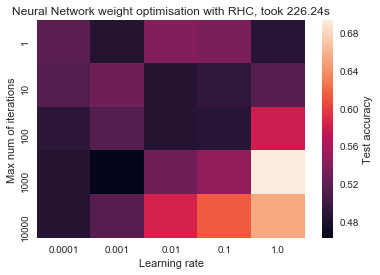

In [25]:
nn_opt_heatmap(rhc, "RHC")

Most performant settings:

- `learning_rate` = 1.0
- `max_iter` = 1000
- gives 69% test accuracy
- overall takes 226 seconds

This test-accuracy heatmap shows a landscape of using RHC to optimised neural network weights by various learning rates and maximum number of iterations. The patches of purple hues at the top left half of the charts indicate that RHC performs poorly on a low learning rate, with a justification that since learning rate represents step size, a step too small would not help the climber escape from a suboptimal. The fact that the leftmost two columns  with learning rate below $lr \leq 0.001$ are consistently dark in colour, reveals that increasing the number of iterations would not help cope with the situation.

Therefore with a higher learning rate, optimally $lr = 1.0$, RHC by `mlrose` performs well, with best accuracy at 69%. This is quite an impressive result, considering backpropagation by `sklearn` gives around 50% of accuracy. (Update after Assignment 1 feedback: the test accuracy of neural network by backpropagation may be inaccurate, that a validation accuracy of around 50% does not appear normal, even though that might actually be inherent to the dataset, there could be further analysis to verify if there are other faulty reasons and fix the model to get a higher test accuracy if that is the case. That is why RHC might not be the best optimisation algorithm to use, and it is hard to judge if 69% is a good enough or even very good accuracy.)

The maximum number of iterations is best at `max_iter = 1000`, and beyond that point, test accuracy starts to fall. This can be explained by balancing exploration and exploitation, that having too many iterations could allow the climber to fall off from the optimum and continue searching.

The time taken is the combined time elapsed for all of the $5\times5$ trials of optimisation. As we shall see the running time of later experiments we can compare in this dimension as well.

## Simulated Annealing (SA)


Note that the `mlrose` library does not provide direct control to temperature, instead it manages the decrement in temperature but allows the choice of the manner of decay. We test on both $ExpDecay$ an exponential decay schdeule, and $GeomDecay$ a geometric decay schedule, to see if the choice would make performance difference.

Intuitively and as explained in the corresponding lecture, the exponential decay schedule appears preferrable: that in each iteration, the search point (i.e. the metal particle by analogy) becomes exponentially more difficult to climb up or down the optimisation landscape, and that the hills and valleys are augmented in the same exponential manner over time or temperature.

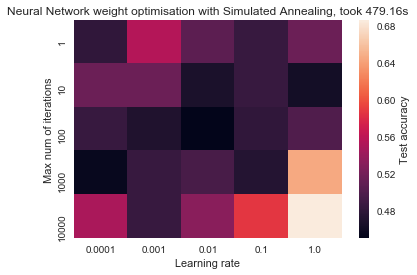

In [247]:
nn_opt_heatmap(sa, "Simulated Annealing")

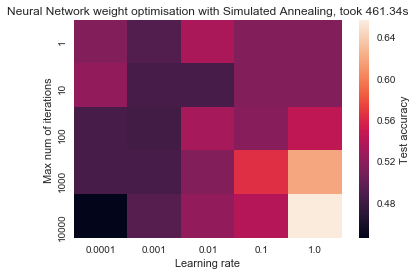

In [262]:
nn_opt_heatmap(sa, "Simulated Annealing", schedule=mlrose.GeomDecay())

*First heatmap: with $ExpDecay$, Second heatmap: with $GeomDecay$*

Most performant settings:

- `schedule` = `ExpDecay`
- `learning_rate` = 1.0
- `max_iter` = 10000
- gives 68% test accuracy
- overall takes 479 seconds

The same heatmaps as that of RHC is plotted for direct comparison. We can see basically a similar heat pattern as RHC. Different from RHC, its optimal weight is attained at `max_iter = 10000`, and that the best test accuracy (from $ExpDecay$) is slightly below RHC. This shows that both SA and RHC are resonably good optimiser to use, compared to the sklearn baseline.

Now compare between the two heatmaps, first notice that the test accuracy scale is different, that with the same brightest cell at the bottom right corner, $ExpDecay$ gives a higher accuracy $68\% > 65\%$. Thus empirically speaking, the choice of $ExpDecay$ is also justified. To provide an explantion, geometric decay works by shrinking the (height of) hills and valleys by a constant multiplcative rate, but this does not align as great as exponential decay does, with stabilising search points to the maxima.

SA takes twice as much time as RHC does, and the test accuracy did not surpass by much. Hence the simpler and faster algorithm, RHC, is more preferrable.

## Genetic Algorithm (GA)

In exploring hyperparameters: Population size controls the degree of crossover, that drives the combination and improvement of previous generations of solutions; Mutation probability defines how probable will each element of the state vector flip. These will be searched on in three trial runs.

genetic_algorithm lr=0.0001, max_iter=1
Training accuracy:  0.5257284562926224
Test accuracy:  0.5123762376237624
genetic_algorithm lr=0.0001, max_iter=10
Training accuracy:  0.5561066336019839
Test accuracy:  0.5767326732673267
genetic_algorithm lr=0.0001, max_iter=100
Training accuracy:  0.6007439553626782
Test accuracy:  0.5965346534653465
genetic_algorithm lr=0.0001, max_iter=1000
Training accuracy:  0.5902045877247365
Test accuracy:  0.5767326732673267
genetic_algorithm lr=0.0001, max_iter=10000
Training accuracy:  0.5908245505269684
Test accuracy:  0.5297029702970297
genetic_algorithm lr=0.001, max_iter=1
Training accuracy:  0.4990700557966522
Test accuracy:  0.4777227722772277
genetic_algorithm lr=0.001, max_iter=10
Training accuracy:  0.49659020458772474
Test accuracy:  0.48514851485148514
genetic_algorithm lr=0.001, max_iter=100
Training accuracy:  0.5939243645381277
Test accuracy:  0.5742574257425742
genetic_algorithm lr=0.001, max_iter=1000
Training accuracy:  0.613763174209

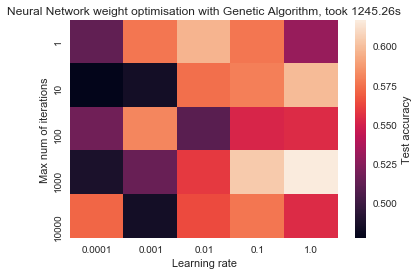

In [255]:
nn_opt_heatmap(ga, "Genetic Algorithm", verbose=True, pop_size=200, mutation_prob=0.1)

genetic_algorithm lr=0.0001, max_iter=1
Training accuracy:  0.5579665220086795
Test accuracy:  0.594059405940594
genetic_algorithm lr=0.0001, max_iter=10
Training accuracy:  0.5610663360198388
Test accuracy:  0.5717821782178217
genetic_algorithm lr=0.0001, max_iter=100
Training accuracy:  0.6013639181649101
Test accuracy:  0.5841584158415841
genetic_algorithm lr=0.0001, max_iter=1000
Training accuracy:  0.6224426534407935
Test accuracy:  0.6089108910891089
genetic_algorithm lr=0.0001, max_iter=10000
Training accuracy:  0.5771853688778673
Test accuracy:  0.5767326732673267
genetic_algorithm lr=0.001, max_iter=1
Training accuracy:  0.6088034717916925
Test accuracy:  0.5965346534653465
genetic_algorithm lr=0.001, max_iter=10
Training accuracy:  0.6125232486050837
Test accuracy:  0.6064356435643564
genetic_algorithm lr=0.001, max_iter=100
Training accuracy:  0.6162430254184749
Test accuracy:  0.594059405940594
genetic_algorithm lr=0.001, max_iter=1000
Training accuracy:  0.6168629882207067

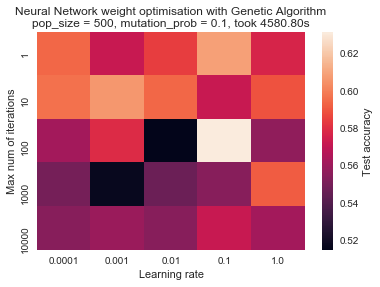

In [264]:
nn_opt_heatmap(ga, "Genetic Algorithm\npop_size = 500, mutation_prob = 0.1", verbose=True, pop_size=500, mutation_prob=0.1)

In [ ]:
nn_opt_heatmap(ga, "Genetic Algorithm\npop_size = 200, mutation_prob = 0.2", verbose=True, pop_size=200, mutation_prob=0.2)

genetic_algorithm lr=0.0001, max_iter=1
Training accuracy:  0.5542467451952883
Test accuracy:  0.5396039603960396
genetic_algorithm lr=0.0001, max_iter=10
Training accuracy:  0.6267823930564166
Test accuracy:  0.5915841584158416
genetic_algorithm lr=0.0001, max_iter=100
Training accuracy:  0.5895846249225046
Test accuracy:  0.5470297029702971
genetic_algorithm lr=0.0001, max_iter=1000
Training accuracy:  0.6460012399256044
Test accuracy:  0.5866336633663366
genetic_algorithm lr=0.0001, max_iter=10000
Training accuracy:  0.6565406075635462
Test accuracy:  0.6287128712871287
genetic_algorithm lr=0.001, max_iter=1
Training accuracy:  0.5598264104153751
Test accuracy:  0.5222772277227723
genetic_algorithm lr=0.001, max_iter=10
Training accuracy:  0.5790452572845629
Test accuracy:  0.5594059405940595
genetic_algorithm lr=0.001, max_iter=100
Training accuracy:  0.6088034717916925
Test accuracy:  0.5866336633663366
genetic_algorithm lr=0.001, max_iter=1000
Training accuracy:  0.60880347179169

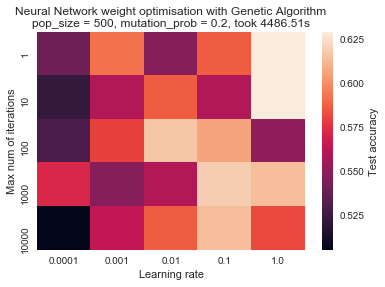

In [265]:
nn_opt_heatmap(ga, "Genetic Algorithm\npop_size = 500, mutation_prob = 0.2", verbose=True, pop_size=500, mutation_prob=0.2)

*First heatmap: with pop_size = 200, mutation_prob = 0.1*

*Second heatmap: with pop_size = 500, mutation_prob = 0.2*

*Third heatmap: with pop_size = 500, mutation_prob = 0.2* Note: two erattas

    - lr=1, max_iter=1: Test accuracy:  0.504950495049505
    - lr=1, max_iter=10: Test accuracy:  0.5643564356435643

Most performant settings:

- `pop_size` = 500
- `mutation_prob` = 0.1
- `learning_rate` = 0.1
- `max_iter` = 100
- gives 63% test accuracy
- overall takes 4580 seconds

Hence we can see that the best setting amongst is the one with `pop_size = 500` and `mutation_prob = 0.1`, giving 63% test accuracy. This is because with a larger population at start, more combinations of solutions can be tested per iteration, giving a better weight. Note that for both the second and third heatmap with `pop_size = 500`, the test accuracy scale is shifted upwards from the first heatmap with `pop_size = 200`, indicating that increase in population size is useful. Mutation probability on the other hand does not seem to contribute much to further raising the test accuracy, but the setting is found to be different: `lr = 0.01`, `max_iter = 10000`. This speaks out that crossover has a greater effect over improving the population than mutation (flipping bits) without loss of generality.

Finally, the overall 25 trials took a ridiculously long time to run, yet it does not surpass RHC or SA in test accuracy, so GA is not deemed the optimal algorithm to use in this scenario.

## Conclusion on weight optimisation

RHC is the best algorithm for this task, as reflected by relatively high test accuracy and quick running time. It works with the setting `learning_rate = 1.0` and `max_iter = 1000`. It is similar to gradient descent in the sense that unlike SA, it always picks the best move to optimise the weights, just as how gradient descent chooses the negative direction of the greatest gradient. This also corresponds to a smooth weight parameter landscape in which hill climbing with continuous moves is suited for.

---

# Three optimisation problems

Setup

- All initial states are random

In [232]:
def experiment(problem, verbose=False, max_attempt=100, pop_size=200):
    rhc, sa, ga, mimic = [], [], [], []
    for max_iter in np.linspace(10, 500, 5):
        max_iter = int(max_iter)
        if verbose:print(f'Max number of Iterations = {max_iter}')
            
        start = timer()
        best_state0, best_fitness0 = mlrose.random_hill_climb(problem,
                                                             max_attempts=max_attempt, max_iters=max_iter,
                                                             restarts=10,
                                                             init_state=None)
        elapsed0 = timer() - start
        if verbose:print(best_state0, best_fitness0, elapsed0)
        rhc.append([max_iter, best_fitness0, elapsed0])
        
        start = timer()
        best_state1, best_fitness1 = mlrose.simulated_annealing(problem,
                                                             schedule=mlrose.ExpDecay(),
                                                             max_attempts=max_attempt, max_iters=max_iter,
                                                             init_state=None)
        elapsed1 = timer() - start
        if verbose:print(best_state1, best_fitness1, elapsed1)
        sa.append([max_iter, best_fitness1, elapsed1])

        start = timer()
        best_state2, best_fitness2 = mlrose.genetic_alg(problem,
                                                      pop_size=pop_size, mutation_prob=0.2, max_attempts=max_attempt,
                                                        max_iters=max_iter)
        elapsed2 = timer() - start
        if verbose:print(best_state2, best_fitness2, elapsed2)
        ga.append([max_iter, best_fitness2, elapsed2])
        
        start = timer()
        best_state3, best_fitness3 = mlrose.mimic(problem,
                                                  pop_size=pop_size, keep_pct=0.2, max_attempts=max_attempt,
                                                     max_iters=max_iter)

        elapsed3 = timer() - start
        if verbose:print(best_state3, best_fitness3, elapsed3)
        mimic.append([max_iter, best_fitness3, elapsed3])
    
    rhc_df = pd.DataFrame(rhc, columns=['max_iter', 'best_fitness', 'time_elapsed'])
    sa_df = pd.DataFrame(sa, columns=['max_iter', 'best_fitness', 'time_elapsed'])
    ga_df = pd.DataFrame(ga, columns=['max_iter', 'best_fitness', 'time_elapsed'])
    mimic_df = pd.DataFrame(mimic, columns=['max_iter', 'best_fitness', 'time_elapsed'])
    return rhc_df, sa_df, ga_df, mimic_df

In [235]:
def plots(problem, problem_name, verbose=False, max_attempt=100, pop_size=200):
    rhc_df, sa_df, ga_df, mimic_df = experiment(problem, verbose, max_attempt, pop_size)
    
    plt.plot(sa_df[['max_iter']], sa_df[['best_fitness']], "--y", label="RHC")
    plt.plot(sa_df[['max_iter']], sa_df[['best_fitness']], "-.", label="SA")
    plt.plot(ga_df[['max_iter']], ga_df[['best_fitness']], "-g", label="GA")
    plt.plot(mimic_df[['max_iter']], mimic_df[['best_fitness']], "-.r", label="MIMIC")
    plt.title(f"{problem_name}: Effect of no. of iterations on fitness value")
    plt.xlabel("No. of iterations")
    plt.ylabel("Best fitness value")
    plt.legend()
    plt.show()

    plt.clf()

    plt.plot(sa_df[['max_iter']], sa_df[['time_elapsed']], "--y", label="RHC")
    plt.plot(sa_df[['max_iter']], sa_df[['time_elapsed']], "-.", label="SA")
    plt.plot(ga_df[['max_iter']], ga_df[['time_elapsed']], "-g", label="GA")
    plt.plot(mimic_df[['max_iter']], mimic_df[['time_elapsed']], "--r", label="MIMIC")
    plt.title(f"{problem_name}: Effect of no. of iterations on time elapsed")
    plt.xlabel("No. of iterations")
    plt.ylabel("Time elapsed")
    plt.legend()
    plt.show()

## Problem 1: OneMax

Illustrates Genetic Algorithm (GA).

The OneMax problem seeks the vector $x = [x_1, x_2, ... x_{n-1}]$ that maximises the sum of all entries (fitness) $$f(x) = \sum_{i=0}^{n-1} x_i$$ This is a common example of a toy but illustrative randomised optimisation problem, because there is one global (obvious to humans) optimum $x^* = [1, 1, ..., 1] = \mathbb{1}$ that is left to the algorithm to explore and search for. This problem has the advantage for quick prototyping for testing algorithms too.

For RHC and SA, they are to climb an $n = 8$ dimensional space (hypercube) to land at the destination.

For GA, this means having multiple partial solutions of $1$'s at various location and combining them by crossover. An edge of GA over RHC and SA is that in a sense RHA and SA are *forgetful*, in that they do not incorporate information from previous attempts to form a better solution the next time, but GA does so by breeding.

For MIMIC, the probability density (technically probability mass in this discrete case) is estimated successively so that more and more mass will accumulate on the $x$ that can maxmimise $f(x)$, through the use of a generated dependency tree to sample the entire density $P(x)$ each iteration, building on previously known conditional dependences. Here the conditional dependence might be interpreted as spreading $1$'s in the $x$ vector such that a vector with all $1$'s is most encouraged by the respective parents of tree nodes.

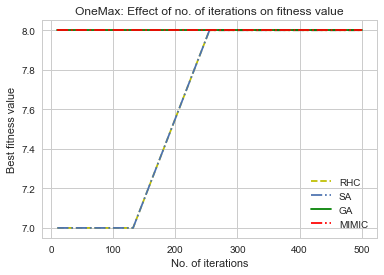

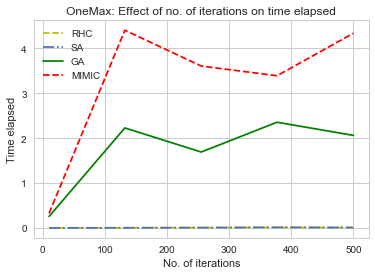

In [236]:
fitness = mlrose.OneMax()
length = 8
problem = mlrose.DiscreteOpt(length=length, fitness_fn=fitness, maximize=True, max_val=2)

plots(problem, "OneMax", verbose=False, max_attempt=100)

These two charts depict the performance of each four algorithms in two aspects of the same experiments:

- Best fitness value attained
- Time elapsed for the search

which are both parameterised on

- Maximum number of iterations

---

Since this is a maximisation problem, and the optimal fitness is simply $f^* = 8$, we can see how GA and MIMIC always hit the correct answer with any number of iteration (5 ticks along `[0, 500]` inclusive). SA and RHC experiences common fate, where at the first two smaller settings of maximum iterations, they settle on a suboptimum of $f(x) = 7$. As more iterations are permitted, they quickly flock to the expected $f(x) = 8$.

In terms of time, RHC and SA handles time complexity well since they do not scale up with number of iterations. MIMIC is expected to suffer from long running time since the density estimation task requires mimium spanning tree building and other expensive subroutines. GA is somewhat in between no-time estimations and the longer one. This is because the crossover operator would suffice in terms of complexity to handle this problem, to combine solutions quickly. MIMIC definitely overkills the task.

To elaborate more on crossover, note that two partial solutions for OneMax can be completely unrelated and far from one another in the searching space, and the crossover operator do not care much on such locality by still gluing the two solutions together. This achieves the effect of jumping across the search space instead of being locked down in the current neighbourhood.

As a result, GA is recognised to be the best algorithm for OneMax.

## Problem 2: Travelling Salesman Problem (TSP)

Illustrates Simulated Annealing (SA).

The travelling salesman problem is a classic puzzle and is famous for being NP-hard in general. We approach this therefore in a randomised/simulated way instead of using a closed form general solver.

This problem is to find a shortest path at which all cities (specified in input as nodes in a graph) are visited exactly once. This is reducible to finding a permutation of the input list of cities that minimises travel distances in between.

$$f(x) = \text{total distance travelled according to tour x}$$

In this particular problem instance, the following cities are used as input. This assumes a complete graph, in which every city is reachable by every other city on the 2D plane, and that the coordinates define their relative locations, meaning that their distance is euclidean distance.

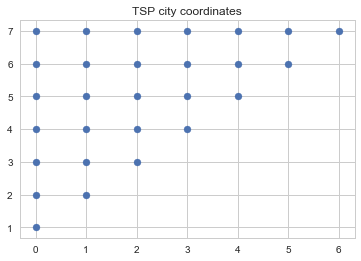

In [260]:
coords_list = [(0, 1), (0, 2), (0, 3), (0, 4), \
             (0, 5), (0, 6), (0, 7), (1, 2), \
             (1, 3), (1, 4), (1, 5), (1, 6), \
             (1, 7), (2, 3), (2, 4), (2, 5), \
             (2, 6), (2, 7), (3, 4), (3, 5), \
             (3, 6), (3, 7), (4, 5), (4, 6), \
             (4, 7), (5, 6), (5, 7), (6, 7)]

x = np.asarray(coords_list)
plt.scatter(x.T[0], x.T[1])
plt.title("TSP city coordinates")
plt.show()

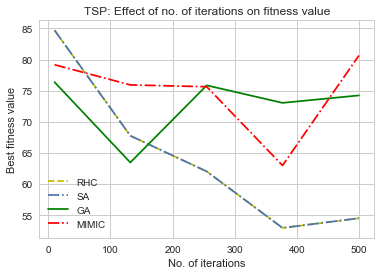

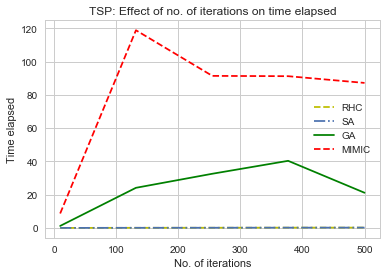

In [237]:
dist_list = [(0, 1, 3.1623), (0, 2, 4.1231), (0, 3, 5.8310), (0, 4, 4.2426), \
             (0, 5, 5.3852), (0, 6, 4.0000), (0, 7, 2.2361), (1, 2, 1.0000), \
             (1, 3, 2.8284), (1, 4, 2.0000), (1, 5, 4.1231), (1, 6, 4.2426), \
             (1, 7, 2.2361), (2, 3, 2.2361), (2, 4, 2.2361), (2, 5, 4.4721), \
             (2, 6, 5.0000), (2, 7, 3.1623), (3, 4, 2.0000), (3, 5, 3.6056), \
             (3, 6, 5.0990), (3, 7, 4.1231), (4, 5, 2.2361), (4, 6, 3.1623), \
             (4, 7, 2.2361), (5, 6, 2.2361), (5, 7, 3.1623), (6, 7, 2.2361)]

fitness_coords = mlrose.TravellingSales(coords=dist_list)

# TSP: minimise distance (specified or coordinated enclidean distance)
problem = mlrose.TSPOpt(length=len(dist_list), fitness_fn=fitness_coords, maximize=False)

plots(problem, "TSP", verbose=False)

These charts follow the same format as Problem 1. The plots of best fitness value are interesting, in that severeal patterns can be observed:

- At a smaller number of iterations, GA outperforms all other algorithms, due to its ability to combine partial local solutions of shortest travelling paths of subsets of cities. RHC and RA are close to that of GA. MIMIC stays higher up in the fitness value, stuck at estimating density but the complication did not help, as seen as its high time complexity requirement too. 
- At higher number of iterations, MIMIC finally reaches a fitness on-par with the previous fitness by GA, but GA bounced up to suboptimals. Meanwhile, SA (and RHC) strives to reach an even lower fitness value that surpasses both of GA and MIMIC. This illustrates the power of trial-and-error in algorithms like hill climbing, that sometimes elaborate planning might not be of great use, and getting cheap explorations could be proven useful.

Considering both a minimum fitness value given enough iterations, and less time elapsed, SA is the best algorithm for solving TSP.

In [ ]:
dist_list = [(0, 1, 3.1623), (0, 2, 4.1231), (0, 3, 5.8310), (0, 4, 4.2426), \
             (0, 5, 5.3852), (0, 6, 4.0000), (0, 7, 2.2361), (1, 2, 1.0000), \
             (1, 3, 2.8284), (1, 4, 2.0000), (1, 5, 4.1231), (1, 6, 4.2426), \
             (1, 7, 2.2361), (2, 3, 2.2361), (2, 4, 2.2361), (2, 5, 4.4721), \
             (2, 6, 5.0000), (2, 7, 3.1623), (3, 4, 2.0000), (3, 5, 3.6056), \
             (3, 6, 5.0990), (3, 7, 4.1231), (4, 5, 2.2361), (4, 6, 3.1623), \
             (4, 7, 2.2361), (5, 6, 2.2361), (5, 7, 3.1623), (6, 7, 2.2361)]

fitness_coords = mlrose.TravellingSales(distances=dist_list)

# TSP: minimise distance (specified or coordinated enclidean distance)
problem = mlrose.TSPOpt(length=len(dist_list), fitness_fn=fitness_coords, maximize=False)

plots(problem, "TSP", verbose=False)

## Problem 3: EightQueens

Illustrates MIMIC.

Queens here refer exactly to those in Chess, and they attack any piece that is either along the same vertical or horizontal line with it, or is along any of the two diagonal lines extending from the queen. It is a corollary that if one queen is attacking another queen, the other queen must also be attacking the first queen, so attacking queens at least come in pairs. Now on a 8-by-8 chess board there are only 8 queens, and there are several arrangements such that no queen would attack any other queen, this optimisation problem prompts to find one of those. In fact $$f(x) = \text{no. of pairs of attacking queens on board x}$$ where $x = [x_0, x_1, ..., x_7]$ and $x_i$ represents the row position (0, 1, ... 7) of the queen $i$th column queen, which in other words sits at coordinate $(i, x_i)$ column-by-row. We are to minimise this cost.

Since this problem also has substructures that some subset of non-attacking queens can form the basis of the full solution, we are expecting better performance from GA and MIMIC.

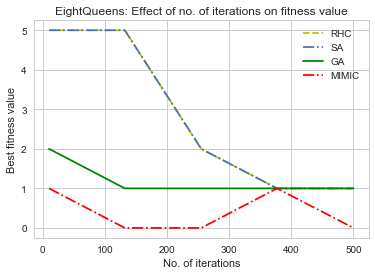

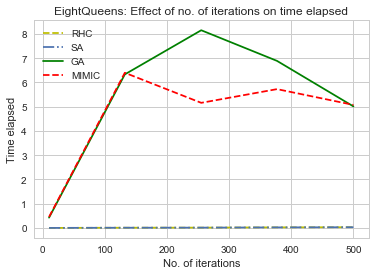

In [242]:
fitness = mlrose.Queens()
length = 8
problem = mlrose.DiscreteOpt(length=length, fitness_fn=fitness, maximize=False, max_val=8)

plots(problem, "EightQueens", pop_size=300)

From these charts, we can see that MIMIC is the only algorithm that can give the best chess arrangement of getting 0 attacking queens at 3 out of 5 times during the 5 different number of maximum iterations. Other algorithms could only give at best a solution with one pair of attacking queens remaining.

Notably RHC and SA leverages the iterations to attain a much better result than initially. GA flattens out at 2. Only MIMIC can precisely solve this problem that involves combination and somewhat a domino effect, since moving a queen to test on another position would definitely affect the unmoved queens, possibly their non-attacking status. EightQueens thus falls into the kind of problems that requires deliberate planning to solve in full. MIMIC prefectly demonstrates its strength through the use of density estimation and using conditional dependence information.

Regarding running time, surprisingly GA runs for longer than MIMIC in higher number of iterations, making MIMIC relatively speaking more efficient. RHC and SA continues to compute in constant time to number of iterations.

As a result, MIMIC is the best algorithm for solving EightQueens.

# Conclusion

After the survey on various optimisation problem across the 4 randomised optimisation algorithm, we come to realise the respective strengths and weaknesses of the algorithms used in different situations:

- Neural Network weight optimisation: RHC
- Linear and combinatory problem (OneMax): GA
- Inherently exploratory problem (TSP): SA/RHC
- Inherently highly interdependent problem (EightQueens): MIMIC

Of course, there is no definite answer to a general-case algorithm, but the lesson is that employ MIMIC when the task needs careful precise moves to optimise and time is not a significant concern, otherwise depending on the problem's nature inclining towards combining subsolutions and exploration, pick GA and SA/RHC respectively. Since there is No Free Lunch, domain knowledge injection is made at the entrance of the fitness function which we have to consider case-by-case for optimality.